In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import nasbench301
import pandas as pd
import seaborn as sns
from naslib import search_spaces
from naslib.search_spaces.core import Metric
from scipy.stats import ttest_rel

from nas import _REPO_ROOT

In [3]:
sns.set_theme()

## Set up

In [4]:
NASBENCH301_DOWNLOAD_DIR = _REPO_ROOT / "models" / "surrogates"

NASBENCH301_MODEL_DIR = NASBENCH301_DOWNLOAD_DIR / "nb_models_1.0"
NASBENCH301_PERFORMANCE_DIR = NASBENCH301_MODEL_DIR / "xgb_v1.0"
NASBENCH301_TIME_DIR = NASBENCH301_MODEL_DIR / "lgb_runtime_v1.0"

NASBENCH301_BENCHMARK_PATH = NASBENCH301_DOWNLOAD_DIR / "nb301_full_training.pickle"

print(NASBENCH301_DOWNLOAD_DIR)
print(NASBENCH301_MODEL_DIR)
print(NASBENCH301_PERFORMANCE_DIR)
print(NASBENCH301_TIME_DIR)
print(NASBENCH301_BENCHMARK_PATH)

/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/models/surrogates
/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/models/surrogates/nb_models_1.0
/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/models/surrogates/nb_models_1.0/xgb_v1.0
/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/models/surrogates/nb_models_1.0/lgb_runtime_v1.0
/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/models/surrogates/nb301_full_training.pickle


In [5]:
nasbench301.download_models(
    version="1.0", delete_zip=True, download_dir=str(NASBENCH301_DOWNLOAD_DIR)
)

Models 1.0 already at /home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/models/surrogates/nb_models_1.0


In [6]:
performance_model = nasbench301.load_ensemble(NASBENCH301_PERFORMANCE_DIR)
runtime_model = nasbench301.load_ensemble(NASBENCH301_TIME_DIR)

nb301_model = [performance_model, runtime_model]
with NASBENCH301_BENCHMARK_PATH.open("rb") as f:
    nb301_data = pickle.load(f)
    nb301_arches = list(nb301_data.keys())

nasbench301_api = {
    "nb301_data": nb301_data,
    "nb301_arches": nb301_arches,
    "nb301_model": nb301_model,
}

/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:11:14] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


## Load

### Direct access to training data 

In [7]:
type(nb301_data)

dict

In [8]:
nb301_data[nb301_arches[0]]

{'runtime': 8328.424762,
 'train_losses': [2.7774760723114014,
  2.454728841781616,
  2.259354591369629,
  2.1267993450164795,
  2.0185439586639404,
  1.9499207735061646,
  1.9115588665008545,
  1.8197637796401978,
  1.7849645614624023,
  1.7689744234085083,
  1.6710821390151978,
  1.6396487951278687,
  1.6082874536514282,
  1.6078178882598877,
  1.5664364099502563,
  1.5298265218734741,
  1.5518540143966675,
  1.47441565990448,
  1.439131498336792,
  1.4864988327026367,
  1.50478994846344,
  1.3726266622543335,
  1.391719102859497,
  1.415298581123352,
  1.3643800020217896,
  1.383301854133606,
  1.3648505210876465,
  1.3280529975891113,
  1.3241406679153442,
  1.331229567527771,
  1.3396148681640625,
  1.3866612911224365,
  1.3036545515060425,
  1.34352707862854,
  1.2502590417861938,
  1.3026782274246216,
  1.2755861282348633,
  1.2422823905944824,
  1.269966721534729,
  1.2718943357467651,
  1.2117857933044434,
  1.2126613855361938,
  1.2430974245071411,
  1.2056118249893188,
  1.2

In [9]:
metrics_list = []
for i, metrics in enumerate(nb301_data.values()):
    _, train_losses, val_accuracies = metrics.values()
    for j, (loss, accuracy) in enumerate(zip(train_losses, val_accuracies)):
        metrics_list.append(
            {"model": i, "step": j, "train_loss": loss, "val_accuracy": accuracy}
        )
metrics_df = pd.DataFrame(metrics_list).convert_dtypes()
metrics_df

,model,step,train_loss,val_accuracy
0,0,0,2.777476,41.650002
1,0,1,2.454729,51.25
2,0,2,2.259355,57.220001
3,0,3,2.126799,63.299999
4,0,4,2.018544,63.540001
...,...,...,...,...
1099653,11220,93,1.042142,91.129997
1099654,11220,94,0.959051,91.389999
1099655,11220,95,0.968897,91.389999
1099656,11220,96,1.03069,91.440002


### Access through `nasbench301` API

So called "labelled" architectures are those from the training set of the surrogate model, that is, those for which training has actually been performed.

In [22]:
nb301_architecture = search_spaces.NasBench301SearchSpace()
nb301_architecture.sample_random_architecture(nasbench301_api, load_labeled=True)
nb301_architecture

Graph makrograph-0.3927139, scope None, 13 nodes

In [23]:
nb301_architecture.query(Metric.VAL_ACCURACY, dataset_api=nasbench301_api)

93.12000274658203

In [24]:
nb301_architecture.query(Metric.TRAIN_TIME, dataset_api=nasbench301_api)

9514.214794

In [25]:
nb301_neighbourhood = nb301_architecture.get_nbhd(nasbench301_api)
len(nb301_neighbourhood)

120

In [26]:
type(nb301_neighbourhood[0].arch)

naslib.search_spaces.nasbench301.graph.NasBench301SearchSpace

In [27]:
nb301_architecture.get_compact()

(((0, 5), (1, 6), (1, 4), (2, 1), (0, 4), (1, 1), (1, 5), (2, 4)),
 ((0, 4), (1, 6), (1, 2), (2, 3), (1, 6), (2, 6), (0, 6), (4, 2)))

In [28]:
nb301_child = search_spaces.NasBench301SearchSpace()
nb301_child.mutate(nb301_architecture)
nb301_child.get_compact()

(((0, 5), (1, 6), (1, 4), (2, 1), (0, 0), (1, 1), (1, 5), (2, 4)),
 ((0, 4), (1, 6), (1, 2), (2, 1), (1, 6), (2, 6), (0, 6), (4, 2)))

## Analyse

<Axes: xlabel='step', ylabel='val_accuracy'>

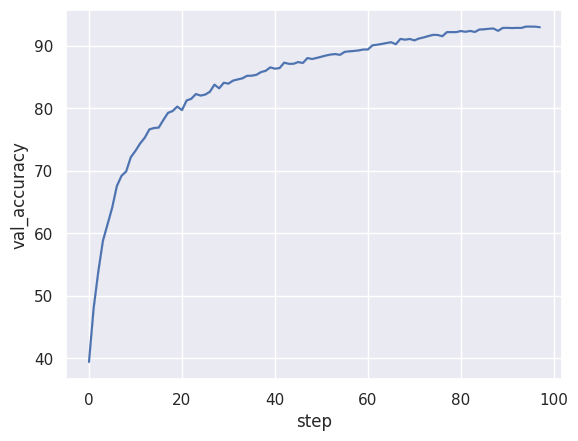

In [10]:
sns.lineplot(metrics_df, x="step", y="val_accuracy")

In [11]:
final_step = metrics_df["step"].max()
final_accuracy = metrics_df[metrics_df["step"] == final_step]["val_accuracy"]

<Axes: ylabel='val_accuracy'>

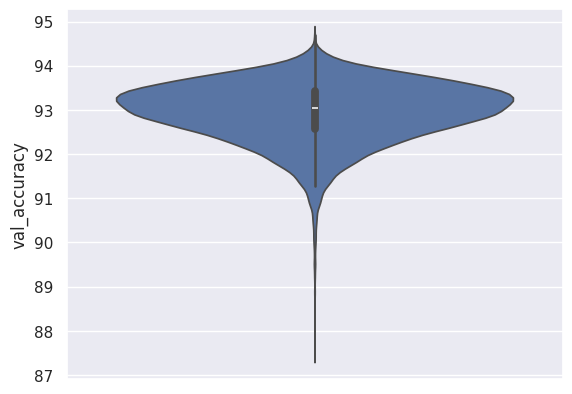

In [12]:
sns.violinplot(metrics_df[metrics_df["step"] == final_step]["val_accuracy"])

<Axes: xlabel='step', ylabel='val_accuracy'>

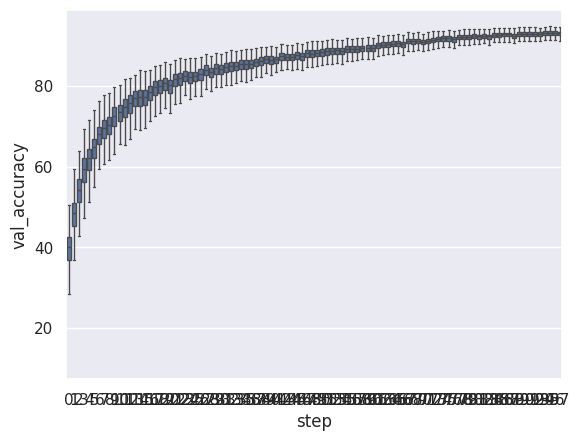

In [13]:
sns.boxplot(metrics_df, x="step", y="val_accuracy", fliersize=0)

<Axes: xlabel='step', ylabel='val_accuracy'>

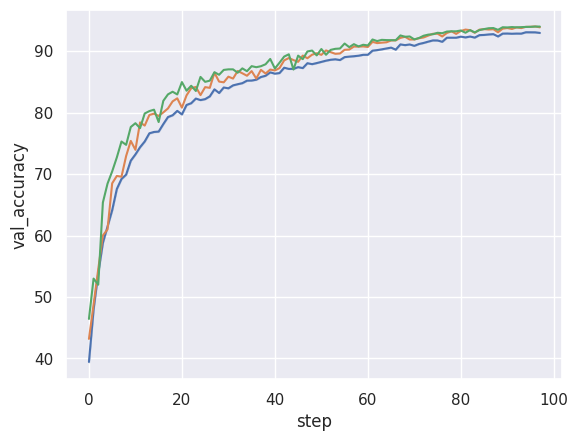

In [14]:
worst_model = metrics_df.loc[final_accuracy.argmin()]["model"]
worst_training = metrics_df[metrics_df["model"] == worst_model]
best_model = metrics_df.loc[final_accuracy.argmax()]["model"]
best_training = metrics_df[metrics_df["model"] == best_model]

sns.lineplot(metrics_df, x="step", y="val_accuracy")
sns.lineplot(worst_training, x="step", y="val_accuracy")
sns.lineplot(best_training, x="step", y="val_accuracy")

In [15]:
ttest_rel(
    best_training["val_accuracy"],
    worst_training["val_accuracy"],
    alternative="greater",
)

TtestResult(statistic=5.58705770152236, pvalue=1.0564175063246942e-07, df=97)

In [16]:
final_accuracy.describe()

count      11221.0
mean     92.959234
std        0.67263
min           87.5
25%      92.580002
50%      93.040001
75%      93.440002
max      94.690002
Name: val_accuracy, dtype: Float64